## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
welly.__version__

'0.3.0'

In [2]:
%%timeit
import os
env = %env


97.1 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
from IPython.display import display

In [4]:
pd.set_option('display.max_rows', 2000)
## pd.set_option('display.height', 2000)

## Notes

In [5]:
## for finding similar geographic points
## scipy spatial kd tree - similar to quad tree ... CKD tree is a little faster as its the C version
## scipy.spatial
## spatial 
## asdfds
##  
## tree.query

## Read In Some Data

In [6]:
## Modifying this slightly to bring in the base McMurray as well
## If we use that as a "pick we already have" it will make the training easier for the "top McMurray" pick.
picks_dic = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('./SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
picks_new=picks[picks['HorID']==13000]
picks_paleoz=picks[picks['HorID']==14000]
df_new = pd.merge(wells, picks_new, on='SitID')
df_paleoz = pd.merge(wells, picks_paleoz, on='SitID')
df_new=pd.merge(df_paleoz, df_new, on='SitID')
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 2192
Data columns (total 11 columns):
SitID          2193 non-null int64
UWI (AGS)_x    2193 non-null object
UWI_x          2193 non-null object
HorID_x        2193 non-null int64
Pick_x         2193 non-null object
Quality_x      2193 non-null int64
UWI (AGS)_y    2193 non-null object
UWI_y          2193 non-null object
HorID_y        2193 non-null int64
Pick_y         2193 non-null object
Quality_y      2193 non-null int64
dtypes: int64(5), object(6)
memory usage: 205.6+ KB


In [8]:


df_new = df_new[["SitID","UWI (AGS)_x","UWI_x","HorID_x","Pick_x","Quality_x","HorID_y","Pick_y","Quality_y"]]
df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI_x"]
df_new["HorID"] = df_new["HorID_y"]
df_new["Pick"] = df_new["Pick_y"]
df_new["Quality"] = df_new["Quality_y"]
df_new["HorID_paleoz"] = df_new["HorID_x"]
df_new["Pick_paleoz"] = df_new["Pick_x"]
df_new["Quality_paleoz"] = df_new["Quality_x"]
df_new = df_new[["SitID","UWI (AGS)","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz"]]
df_new

,SitID,UWI (AGS),UWI,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz
0,102496,0674010812000,00/12-08-067-01W4/0,13000,475,3,14000,561,1
1,102497,0674020807000,00/07-08-067-02W4/0,13000,515,3,14000,604.5,1
2,102498,0674021109000,00/09-11-067-02W4/0,13000,480,3,14000,564,1
3,102500,0674022910000,00/10-29-067-02W4/0,13000,549,3,14000,636.5,1
4,102501,0674023406000,00/06-34-067-02W4/0,13000,529,2,14000,613,1
5,102503,0674030411000,00/11-04-067-03W4/0,13000,488.5,2,14000,553.5,1
6,102505,0674030810000,00/10-08-067-03W4/0,13000,501.5,2,14000,572.5,1
7,102507,0674031410000,00/10-14-067-03W4/0,13000,553.5,2,14000,606.5,1
8,102514,0674032810000,00/10-28-067-03W4/0,13000,493.5,3,14000,558,1
9,102517,0674033607000,00/07-36-067-03W4/0,13000,536.5,2,14000,615,1


In [9]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

2193

In [10]:
#### reading in an example well for testing
#  w_test_df = lasio.read(well_path+"00-01-04-075-23W4-0.LAS").df()
# w_test_df.df()


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [11]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [12]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [13]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [14]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [15]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [16]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [ ]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1200
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('./SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] < 10:
                    l_df = l_df.reset_index()
                    print("got to UWI apppend")
                    l_df['UWI'] = str_uwi
                    print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                    l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
                    l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                    l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                    l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                    l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                    #### adding in paleozoic surface pick
                    l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                    l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                    l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]

                    print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                    try:
                        print("in first try statement, count = ",count)
                        float(l_df.Pick.unique()[0])
                        l_df.Pick = l_df.Pick.astype(float)
                        l_df.DEPT = l_df.DEPT.astype(float)
                        l_df['new_pick']=l_df['Pick']-l_df['DEPT']
                        l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                        #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                        float(l_df.Pick_paleoz.unique()[0])
                        l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                        #l_df.DEPT = l_df.DEPT.astype(float)
                        l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                        l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)

                        print("got to below astype part")
                        #### instead of concat into a single dataframe, run functions & then add to dictionary   
                        ##### run functions to create features on array basis for each well in separate dataframe
                        ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                        ##### and will make it easier to write data back to LAS if we run into memory limitations later
                        curves = ['GR','ILD']
                        windows = [5,7,11,21]
                        directions = ["around","below","above"]
                        comboArg_A = [curves,windows,directions]
                        all_comboArgs_A = list(itertools.product(*comboArg_A))
                        for eachArgList in all_comboArgs_A:
                            try:
                                l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                            except:
                                pass
                        #### add resultant dataframe to dictionary
                        if l_df['DEPT'].max() < 600:
                            df_w_dict[l_df_new['UWI'][0]]= l_df_new
                    except ValueError as e:
                        print("e = ",e)
                        print ('Error picking')
                        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                        message = template.format(type(e).__name__, e.args)
                        print("message = ",message)
                        print("file = ",file)
                        print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                        list_of_failed_wells.append(str_uwi)
                        #continue;
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [ ]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/01-01-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  607
in first try statement, count =  1
got to below astype part
got to UWI apppend
UWI added is  00/01-01-095-19W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  2
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-01-01-095-19W4-0.LAS
Got except, UWI added is  00/01-01-095-19W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/01-03-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  243
in first try statement, count =  3
got to below astype part
got to UWI apppend
UWI added is  00/01-04-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  631
in first try statement, count =  4
got to below ast

got to UWI apppend
UWI added is  00/02-26-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  580
in first try statement, count =  37
got to below astype part
got to UWI apppend
UWI added is  00/02-26-076-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  368.5
in first try statement, count =  38
got to below astype part
got to UWI apppend
UWI added is  00/02-27-076-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.5
in first try statement, count =  39
got to below astype part
got to UWI apppend
UWI added is  00/02-29-067-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  493
in first try statement, count =  40
got to below astype part
got to UWI apppend
UWI added is  00/02-29-073-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  455
in first try statement, count =  41
got to below astype part
got to UWI apppend
UWI added is  00/02-29-080-13W4/0  and type is  <class 'str'>
got t

got to UWI apppend
UWI added is  00/03-25-083-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  468
in first try statement, count =  75
got to below astype part
got to UWI apppend
UWI added is  00/03-28-077-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  365.46
in first try statement, count =  76
got to below astype part
got to UWI apppend
UWI added is  00/03-28-095-18W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  77
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-03-28-095-18W4-0.LAS
Got except, UWI added is  00/03-28-095-18W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/03-30-074-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  473.66
in first try statement, count =  78
got to

got to UWI apppend
UWI added is  00/04-26-077-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  460
in first try statement, count =  111
got to below astype part
got to UWI apppend
UWI added is  00/04-26-084-15W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  112
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-04-26-084-15W4-0.LAS
Got except, UWI added is  00/04-26-084-15W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/04-29-076-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  843
in first try statement, count =  113
got to below astype part
got to UWI apppend
UWI added is  00/04-30-078-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  451.5
in first try statement, count =  114
got to

got to UWI apppend
UWI added is  00/05-14-080-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  429
in first try statement, count =  144
got to below astype part
got to UWI apppend
UWI added is  00/05-15-069-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  468
in first try statement, count =  145
got to below astype part
got to UWI apppend
UWI added is  00/05-15-078-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  314
in first try statement, count =  146
got to below astype part
got to UWI apppend
UWI added is  00/05-15-080-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  417.5
in first try statement, count =  147
got to below astype part
got to UWI apppend
UWI added is  00/05-18-071-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  879
in first try statement, count =  148
got to below astype part
got to UWI apppend
UWI added is  00/05-19-070-05W4/0  and type is  <class 'str'>
go

got to UWI apppend
UWI added is  00/06-01-093-21W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  183
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-06-01-093-21W4-0.LAS
Got except, UWI added is  00/06-01-093-21W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/06-02-072-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  603.5
in first try statement, count =  184
got to below astype part
got to UWI apppend
UWI added is  00/06-02-072-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  492.25
in first try statement, count =  185
got to below astype part
got to UWI apppend
UWI added is  00/06-02-076-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  524.87
in first try statement, count =  186


got to UWI apppend
UWI added is  00/06-06-082-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  314.55
in first try statement, count =  220
got to below astype part
got to UWI apppend
UWI added is  00/06-06-084-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  274
in first try statement, count =  221
got to below astype part
got to UWI apppend
UWI added is  00/06-07-069-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  531
in first try statement, count =  222
got to below astype part
got to UWI apppend
UWI added is  00/06-07-070-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  436.78
in first try statement, count =  223
got to below astype part
got to UWI apppend
UWI added is  00/06-07-070-20W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  224
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError o

got to UWI apppend
UWI added is  00/06-11-078-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  274.93
in first try statement, count =  257
got to below astype part
got to UWI apppend
UWI added is  00/06-11-079-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  372.47
in first try statement, count =  258
got to below astype part
got to UWI apppend
UWI added is  00/06-11-082-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  200.56
in first try statement, count =  259
got to below astype part
got to UWI apppend
UWI added is  00/06-11-087-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  327.36
in first try statement, count =  260
got to below astype part
got to UWI apppend
UWI added is  00/06-11-089-25W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  261
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueE

got to UWI apppend
UWI added is  00/06-17-076-19W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  296
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-06-17-076-19W4-0.LAS
Got except, UWI added is  00/06-17-076-19W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/06-17-077-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  637.03
in first try statement, count =  297
got to below astype part
got to UWI apppend
UWI added is  00/06-17-078-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  517.55
in first try statement, count =  298
got to below astype part
got to UWI apppend
UWI added is  00/06-18-070-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  665.07
in first try statement, count =  299

got to UWI apppend
UWI added is  00/06-23-083-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  291.5
in first try statement, count =  339
got to below astype part
got to UWI apppend
UWI added is  00/06-23-085-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  226.5
in first try statement, count =  340
got to below astype part
got to UWI apppend
UWI added is  00/06-23-085-18W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  341
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-06-23-085-18W4-0.LAS
Got except, UWI added is  00/06-23-085-18W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/06-24-070-21W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  342

got to UWI apppend
UWI added is  00/06-28-076-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  517
in first try statement, count =  378
got to below astype part
got to UWI apppend
UWI added is  00/06-28-076-19W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  379
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-06-28-076-19W4-0.LAS
Got except, UWI added is  00/06-28-076-19W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/06-28-079-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  401.12
in first try statement, count =  380
got to below astype part
got to UWI apppend
UWI added is  00/06-28-087-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  301.75
in first try statement, count =  381
go

got to UWI apppend
UWI added is  00/06-32-079-02W5/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  416
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-06-32-079-02W5-0.LAS
Got except, UWI added is  00/06-32-079-02W5/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/06-32-082-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  273.1
in first try statement, count =  417
got to below astype part
got to UWI apppend
UWI added is  00/06-33-070-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  448
in first try statement, count =  418
got to below astype part
got to UWI apppend
UWI added is  00/06-33-070-21W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  419
e

got to UWI apppend
UWI added is  00/06-36-075-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  360
in first try statement, count =  453
got to below astype part
got to UWI apppend
UWI added is  00/06-36-075-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  541.32
in first try statement, count =  454
got to below astype part
got to UWI apppend
UWI added is  00/06-36-076-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  779.68
in first try statement, count =  455
got to below astype part
got to UWI apppend
UWI added is  00/06-36-077-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  582.17
in first try statement, count =  456
got to below astype part
got to UWI apppend
UWI added is  00/06-36-080-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  414.53
in first try statement, count =  457
got to below astype part
got to UWI apppend
UWI added is  00/06-36-082-16W4/0  and type is  <class

got to UWI apppend
UWI added is  00/07-06-072-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  593.14
in first try statement, count =  490
got to below astype part
got to UWI apppend
UWI added is  00/07-06-077-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  727.25
in first try statement, count =  491
got to below astype part
got to UWI apppend
UWI added is  00/07-06-078-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.17
in first try statement, count =  492
got to below astype part
got to UWI apppend
UWI added is  00/07-06-079-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  295.5
in first try statement, count =  493
got to below astype part
got to UWI apppend
UWI added is  00/07-06-080-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  291
in first try statement, count =  494
got to below astype part
got to UWI apppend
UWI added is  00/07-06-083-03W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/07-11-073-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  483
in first try statement, count =  527
got to below astype part
got to UWI apppend
UWI added is  00/07-11-074-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  649.22
in first try statement, count =  528
got to below astype part
got to UWI apppend
UWI added is  00/07-11-077-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  660.81
in first try statement, count =  529
got to below astype part
got to UWI apppend
UWI added is  00/07-11-078-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  548.03
in first try statement, count =  530
got to below astype part
got to UWI apppend
UWI added is  00/07-11-078-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  350.52
in first try statement, count =  531
got to below astype part
got to UWI apppend
UWI added is  00/07-11-078-17W4/0  and type is  <class

got to UWI apppend
UWI added is  00/07-16-070-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  464.5
in first try statement, count =  566
got to below astype part
got to UWI apppend
UWI added is  00/07-16-070-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  452.93
in first try statement, count =  567
got to below astype part
got to UWI apppend
UWI added is  00/07-16-072-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  654.71
in first try statement, count =  568
got to below astype part
got to UWI apppend
UWI added is  00/07-16-077-04W5/0  and type is  <class 'str'>
got to end of col append & pick is  621.18
in first try statement, count =  569
got to below astype part
got to UWI apppend
UWI added is  00/07-16-077-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  482
in first try statement, count =  570
got to below astype part
got to UWI apppend
UWI added is  00/07-16-079-24W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/07-21-081-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  416
in first try statement, count =  606
got to below astype part
got to UWI apppend
UWI added is  00/07-21-084-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  342
in first try statement, count =  607
got to below astype part
got to UWI apppend
UWI added is  00/07-22-073-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  558.39
in first try statement, count =  608
got to below astype part
got to UWI apppend
UWI added is  00/07-22-076-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  550.16
in first try statement, count =  609
got to below astype part
got to UWI apppend
UWI added is  00/07-22-077-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  341
in first try statement, count =  610
got to below astype part
got to UWI apppend
UWI added is  00/07-22-077-15W4/0  and type is  <class 'str'

got to UWI apppend
UWI added is  00/07-25-080-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  240.5
in first try statement, count =  640
got to below astype part
got to UWI apppend
UWI added is  00/07-25-083-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  285.5
in first try statement, count =  641
got to below astype part
got to UWI apppend
UWI added is  00/07-26-074-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  418.25
in first try statement, count =  642
got to below astype part
got to UWI apppend
UWI added is  00/07-26-075-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  582.78
in first try statement, count =  643
got to below astype part
got to UWI apppend
UWI added is  00/07-26-076-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  461.47
in first try statement, count =  644
got to below astype part
got to UWI apppend
UWI added is  00/07-26-079-10W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/07-30-072-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  593.75
in first try statement, count =  675
got to below astype part
got to UWI apppend
UWI added is  00/07-30-075-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  552
in first try statement, count =  676
got to below astype part
got to UWI apppend
UWI added is  00/07-31-069-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  440
in first try statement, count =  677
got to below astype part
got to UWI apppend
UWI added is  00/07-31-069-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  437
in first try statement, count =  678
got to below astype part
got to UWI apppend
UWI added is  00/07-31-070-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  495
in first try statement, count =  679
got to below astype part
got to UWI apppend
UWI added is  00/07-31-070-24W4/0  and type is  <class 'str'>
g

got to UWI apppend
UWI added is  00/07-35-074-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  578.51
in first try statement, count =  713
got to below astype part
got to UWI apppend
UWI added is  00/07-35-075-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  409
in first try statement, count =  714
got to below astype part
got to UWI apppend
UWI added is  00/07-35-078-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  410.26
in first try statement, count =  715
got to below astype part
got to UWI apppend
UWI added is  00/07-35-088-24W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  716
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-07-35-088-24W4-0.LAS
Got except, UWI added is  00/07-35-088-24W4/0  and 

got to UWI apppend
UWI added is  00/08-14-073-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  601.98
in first try statement, count =  750
got to below astype part
got to UWI apppend
UWI added is  00/08-16-069-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  443
in first try statement, count =  751
got to below astype part
got to UWI apppend
UWI added is  00/08-16-072-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  481
in first try statement, count =  752
got to below astype part
got to UWI apppend
UWI added is  00/08-16-075-05W5/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  753
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-08-16-075-05W5-0.LAS
Got except, UWI added is  00/08-16-075-05W5/0  and typ

got to UWI apppend
UWI added is  00/09-11-068-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  514
in first try statement, count =  783
got to below astype part
got to UWI apppend
UWI added is  00/09-11-077-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  452.5
in first try statement, count =  784
got to below astype part
got to UWI apppend
UWI added is  00/09-12-070-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  477
in first try statement, count =  785
got to below astype part
got to UWI apppend
UWI added is  00/09-13-072-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  474
in first try statement, count =  786
got to below astype part
got to UWI apppend
UWI added is  00/09-13-083-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  232
in first try statement, count =  787
got to below astype part
got to UWI apppend
UWI added is  00/09-14-071-06W4/0  and type is  <class 'str'>
go

got to UWI apppend
UWI added is  00/10-01-079-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  504.14
in first try statement, count =  822
got to below astype part
got to UWI apppend
UWI added is  00/10-01-079-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  386.49
in first try statement, count =  823
got to below astype part
got to UWI apppend
UWI added is  00/10-01-082-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  287.73
in first try statement, count =  824
got to below astype part
got to UWI apppend
UWI added is  00/10-01-082-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  316.38
in first try statement, count =  825
got to below astype part
got to UWI apppend
UWI added is  00/10-01-082-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  416.36
in first try statement, count =  826
got to below astype part
got to UWI apppend
UWI added is  00/10-01-084-16W4/0  and type is  <cl

got to UWI apppend
UWI added is  00/10-05-079-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  288.34
in first try statement, count =  861
got to below astype part
got to UWI apppend
UWI added is  00/10-05-080-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  364
in first try statement, count =  862
got to below astype part
got to UWI apppend
UWI added is  00/10-06-067-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  508
in first try statement, count =  863
got to below astype part
got to UWI apppend
UWI added is  00/10-06-073-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.27
in first try statement, count =  864
got to below astype part
got to UWI apppend
UWI added is  00/10-06-074-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  470.92
in first try statement, count =  865
got to below astype part
got to UWI apppend
UWI added is  00/10-06-076-07W4/0  and type is  <class 's

got to UWI apppend
UWI added is  00/10-09-074-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  472.44
in first try statement, count =  897
got to below astype part
got to UWI apppend
UWI added is  00/10-09-078-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  349.3
in first try statement, count =  898
got to below astype part
got to UWI apppend
UWI added is  00/10-09-078-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  508.5
in first try statement, count =  899
got to below astype part
got to UWI apppend
UWI added is  00/10-09-080-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  225.55
in first try statement, count =  900
got to below astype part
got to UWI apppend
UWI added is  00/10-09-082-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  197.51
in first try statement, count =  901
got to below astype part
got to UWI apppend
UWI added is  00/10-10-069-15W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/10-14-073-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  458
in first try statement, count =  934
got to below astype part
got to UWI apppend
UWI added is  00/10-14-074-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  438.8
in first try statement, count =  935
got to below astype part
got to UWI apppend
UWI added is  00/10-14-077-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  392.5
in first try statement, count =  936
got to below astype part
got to UWI apppend
UWI added is  00/10-14-078-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  362.1
in first try statement, count =  937
got to below astype part
got to UWI apppend
UWI added is  00/10-14-080-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  370.03
in first try statement, count =  938
got to below astype part
got to UWI apppend
UWI added is  00/10-14-081-17W4/0  and type is  <class 's

got to UWI apppend
UWI added is  00/10-17-072-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  487.68
in first try statement, count =  969
got to below astype part
got to UWI apppend
UWI added is  00/10-17-073-04W5/0  and type is  <class 'str'>
got to end of col append & pick is  569
in first try statement, count =  970
got to below astype part
got to UWI apppend
UWI added is  00/10-17-073-17W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  971
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-10-17-073-17W4-0.LAS
Got except, UWI added is  00/10-17-073-17W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/10-17-074-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  546
in first try statement, count =  972
got t

got to UWI apppend
UWI added is  00/10-20-076-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  532.79
in first try statement, count =  1002
got to below astype part
got to UWI apppend
UWI added is  00/10-20-076-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  856.49
in first try statement, count =  1003
got to below astype part
got to UWI apppend
UWI added is  00/10-20-078-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  478.84
in first try statement, count =  1004
got to below astype part
got to UWI apppend
UWI added is  00/10-20-080-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  404.16
in first try statement, count =  1005
got to below astype part
got to UWI apppend
UWI added is  00/10-20-082-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  246.58
in first try statement, count =  1006
got to below astype part
got to UWI apppend
UWI added is  00/10-20-083-20W4/0  and type is

got to UWI apppend
UWI added is  00/10-23-090-24W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  1040
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-10-23-090-24W4-0.LAS
Got except, UWI added is  00/10-23-090-24W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/10-24-073-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  475
in first try statement, count =  1041
got to below astype part
got to UWI apppend
UWI added is  00/10-24-081-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  434.64
in first try statement, count =  1042
got to below astype part
got to UWI apppend
UWI added is  00/10-24-083-19W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  1

got to UWI apppend
UWI added is  00/10-27-079-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  497.43
in first try statement, count =  1079
got to below astype part
got to UWI apppend
UWI added is  00/10-27-080-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  244.45
in first try statement, count =  1080
got to below astype part
got to UWI apppend
UWI added is  00/10-27-080-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  335.89
in first try statement, count =  1081
got to below astype part
got to UWI apppend
UWI added is  00/10-27-081-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  386.5
in first try statement, count =  1082
got to below astype part
got to UWI apppend
UWI added is  00/10-27-082-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  192
in first try statement, count =  1083
got to below astype part
got to UWI apppend
UWI added is  00/10-27-082-24W4/0  and type is  <c

got to UWI apppend
UWI added is  00/10-32-073-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.78
in first try statement, count =  1121
got to below astype part
got to UWI apppend
UWI added is  00/10-32-075-20W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  1122
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-10-32-075-20W4-0.LAS
Got except, UWI added is  00/10-32-075-20W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/10-32-076-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  371.86
in first try statement, count =  1123
got to below astype part
got to UWI apppend
UWI added is  00/10-32-076-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  475.95
in first try statement, count =  

In [ ]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [ ]:
#print(df_w_dict)

In [ ]:
print("list_of_failed_wells",list_of_failed_wells)

In [ ]:
df_w_dict['00/04-13-077-05W4/0']

In [ ]:
## testing one dataframe of one well in dictionary of all that were successfully read in
#df_w_dict['00/01-03-085-15W4/0'].shape

In [ ]:
print(len(df_w_dict))

## Turn dictionary of dataframes into single dataframe

In [ ]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [ ]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

In [ ]:
type(data_df)

In [ ]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

## Key variables that hold data frame column names

In [ ]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [ ]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [ ]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

In [ ]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [ ]:
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [ ]:
train_X2.shape

In [ ]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

In [ ]:
well_data=data_df.copy()

In [ ]:
well_data.shape

In [ ]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [ ]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [ ]:
seed = 123

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [ ]:
model = XGBRegressor(
   gamma=0, 
   reg_alpha=0.2, 
   max_depth=3, 
   subsample=0.8, 
   colsample_bytree= 0.8, 
   n_estimators= 300, 
   learning_rate= 0.03, 
   min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

In [ ]:
from xgboost import plot_importance
plot_imp = plot_importance(model)
fig = plot_imp.figure
fig.set_size_inches(12, 20)

In [ ]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

In [ ]:
len(test_df_pred.UWI.unique())

In [ ]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

In [ ]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

In [ ]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [ ]:
test_df_pred2['pred_error'] = test_df_pred2['DEPT'] - test_df_pred2['Pick']
#test_df_pred2['pred_error','DEPT','Pick'].head()
# scratch =  test_df_pred2['pred_error','DEPT','Pick']
# scratch.head()

In [ ]:
### checking that test_df_pred2['pred_error'] was made correctly
scratch = test_df_pred2[['pred_error','DEPT','Pick']]
scratch.head()

In [ ]:
plt.hist(test_df_pred2['pred_error'], bins=15, color='red', label='label goes here')
plt.xlabel('true pick depth - predicted depth')
plt.ylabel('# predictions')
plt.title('prediction error')

In [ ]:
#plt.hist(test_df_pred2['pred_error'], bins=15, color='red', label='label goes here')
plt.scatter(test_df_pred2['pred_error'],test_df_pred2['DEPT'], s=2)
plt.xlabel('true pick depth - predicted depth = error')
plt.ylabel('Depth')
plt.title('prediction error vs. Depth')

In [ ]:
#plt.hist(test_df_pred2['pred_error'], bins=15, color='red', label='label goes here')
plt.scatter(test_df_pred2['pred_error'],test_df_pred2['DEPT'], s=2)
plt.xlabel('true pick depth - predicted depth = error')
plt.ylabel('Depth')
plt.title('prediction error vs. Depth')

In [50]:
#test_df_pred2['new_pick_paleoz']

In [51]:
#plt.scatter(test_df_pred2['DEPT'],test_df_pred2['new_pick_paleoz'], s=2)
#plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
##plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
#plt.xlabel('base pick actual')
#plt.ylabel('Predicted Depth')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1356d96d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13cf95eb8>]], dtype=object)

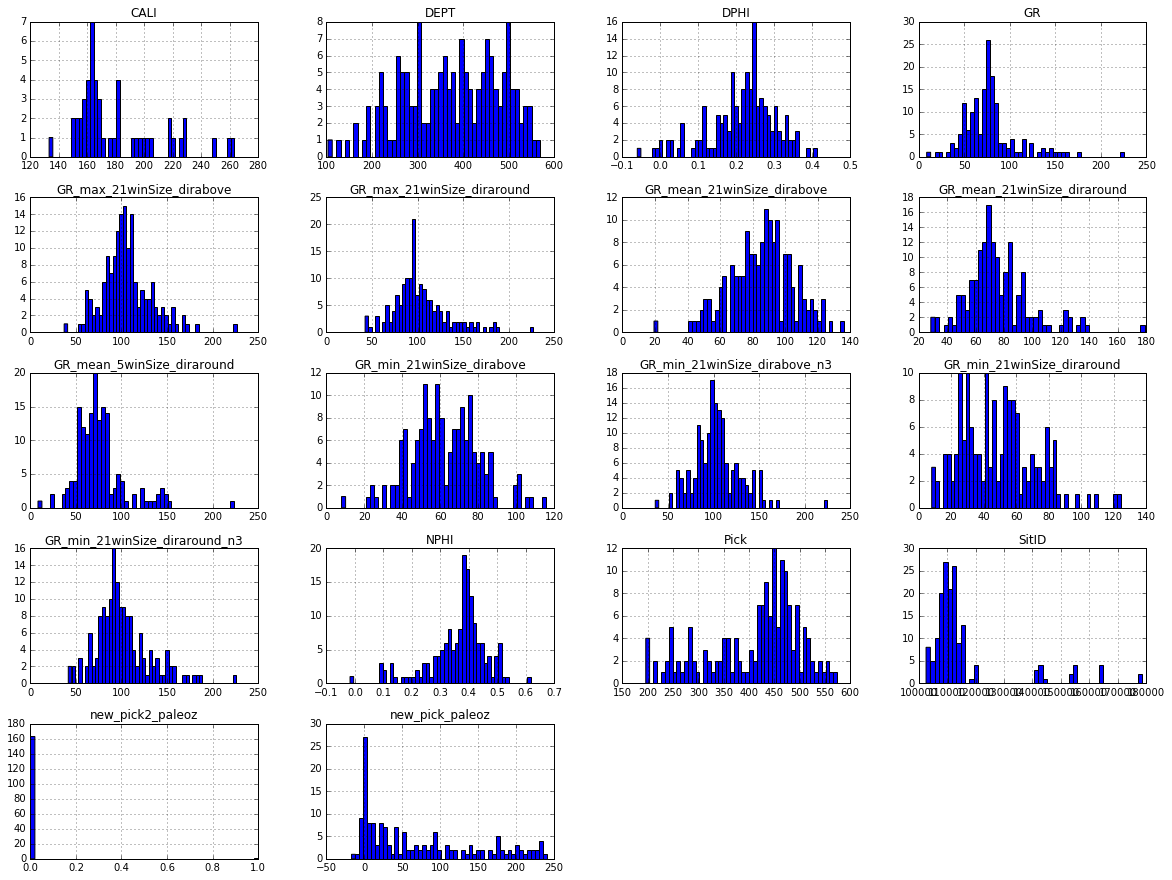

In [52]:
display= ['CALI','DEPT','DPHI','GR','NPHI', 'SitID','new_pick_paleoz','new_pick2_paleoz','Pick',
         'GR_mean_5winSize_diraround',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
         ]
df_display=test_df_pred2[display]
df_display.hist(bins=50, figsize=(20,15))

In [53]:
#tracks = ['CALI', 'GR', 'DPHI', 'NPHI', 'ILD']
#w = Well.from_las(test_df_pred2)
#w.plot(tracks=tracks)

In [54]:
## this well exists in the dataframe used in training?   '00/04-13-077-05W4/0'


In [55]:
test_df_pred2.UWI.unique()

array(['00/10-26-091-18W4/0', '00/10-20-075-18W4/0', '00/09-04-084-04W4/0',
       '00/06-25-073-17W4/0', '00/06-34-084-16W4/0', '00/10-27-068-13W4/0',
       '00/07-12-092-18W4/0', '00/06-23-074-17W4/0', '00/10-01-082-17W4/0',
       '00/07-24-076-07W4/0', '00/05-13-071-10W4/0', '00/07-01-079-24W4/0',
       '00/09-24-071-06W4/0', '00/09-34-074-10W4/0', '00/07-01-084-19W4/0',
       '00/06-34-081-21W4/0', '00/11-04-074-15W4/0', '00/10-25-072-09W4/0',
       '00/06-17-076-10W4/0', '00/06-23-082-22W4/0', '00/07-14-079-02W5/0',
       '00/04-12-081-23W4/0', '00/06-24-084-16W4/0', '00/06-23-075-07W4/0',
       '00/07-20-076-09W4/0', '00/07-31-069-12W4/0', '00/08-05-067-12W4/0',
       '00/06-02-072-20W4/0', '00/10-11-080-09W4/0', '00/06-36-075-06W4/0',
       '00/01-32-080-22W4/0', '00/06-06-074-19W4/0', '00/06-02-092-19W4/0',
       '00/10-11-078-14W4/0', '00/07-17-075-03W4/0', '00/07-09-081-02W5/0',
       '00/06-09-073-14W4/0', '00/07-24-071-17W4/0', '00/03-04-072-09W4/0',
       '00/0

In [56]:
#'00/10-09-078-09W4/0'
#l_df = lasio.read(file).df()
#'./SPE_006_originalData/OilSandsDB/Logs/*.LAS'

#exp_l_df = lasio.read('./SPE_006_originalData/OilSandsDB/Logs/'+'00/10-09-078-09W4/0'+'.LAS').df()
#df_pred_well = test_df_pred2[test_df_pred2['UWI'] == '00/10-09-078-09W4/0']


In [57]:
df_pred_well = test_df_pred2[test_df_pred2['UWI'] == '00/10-09-078-09W4/0']
df_pred_well

,CALI,COND,DELT,DEPT,DPHI,DT,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,GR_max_21winSize_dirabove,...,Quality_paleoz,RHOB,SitID,UWI,UWI (AGS),new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred
739,NaN,NaN,NaN,364.582,0.239,NaN,50.159,83.156,83.156,100.959,...,1,2301.85,111022,00/10-09-078-09W4/0,0784090910000,-15.282,0,0,33.488,0.005087


In [58]:
well_path = 'SPE_006_originalData/OilSandsDB/Logs/'
w = Well.from_las(well_path+'00-10-09-078-09W4-0.LAS')
w

In [59]:
print(type(w))

<class 'welly.well.Well'>


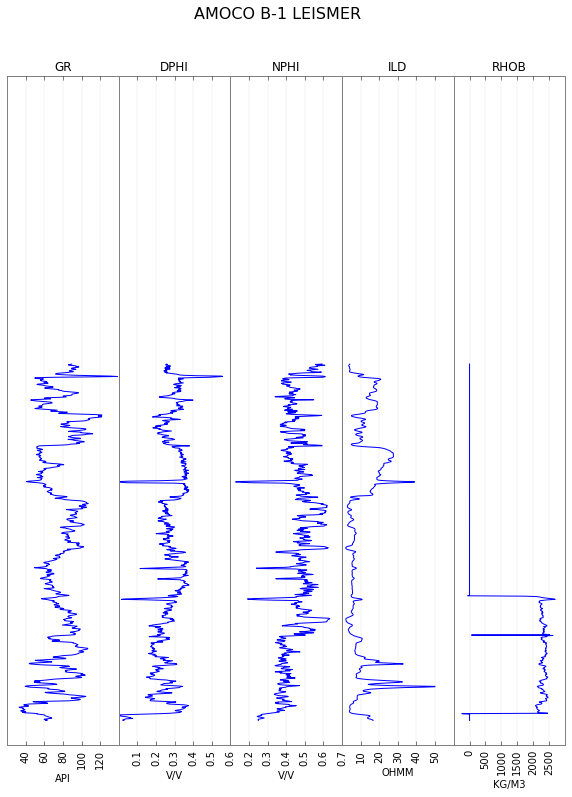

In [60]:
tracks = ['GR', 'DPHI', 'NPHI', 'ILD','RHOB']
w.plot(tracks=tracks)

In [61]:
#w_df = w.df()
print(type(w))

<class 'welly.well.Well'>


In [62]:
#w_df = w.df()
#w_df

In [63]:
#w = Well.from_las(well_path+'00-10-09-078-09W4-0.LAS')
w_2 = lasio.read(well_path+'00-10-09-078-09W4-0.LAS')
w_df = w_2.df()
print(type(w_df))

<class 'pandas.core.frame.DataFrame'>


In [64]:
merged_df_of_well =  pd.concat([w_df, df_pred_well], axis=1)
merged_df_of_well.head()


,RHOB,GR,DPHI,NPHI,ILD,CALI,COND,DELT,DEPT,DPHI,...,Quality_paleoz,RHOB,SitID,UWI,UWI (AGS),new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred
179.832,0.0,89.392,0.256,0.593,4.191,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.082,0.0,87.675,0.261,0.557,4.002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.332,0.0,85.737,0.252,0.561,3.806,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.582,0.0,86.882,0.262,0.608,3.632,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.832,0.0,92.636,0.270,0.580,3.625,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
merged_df_of_well = merged_df_of_well['DEPT','GR','Pick']

KeyError: ('DEPT', 'GR', 'Pick')

In [ ]:
w_2.set_data_from_df(merged_df_of_well, truncate=False)    # triggers LASFile to create a new CurveItem - otherwise it'll be silently ignored.



In [ ]:
print(type(w_2))

In [ ]:
w_2

In [ ]:
fn = "scratch.las"
with open(fn, mode="w") as f: # Write LAS file to disk
    w_2.write(f)

In [ ]:
#w_2asdfasdf = lasio.read("scratch.las")
#w_2asdfasdf

In [ ]:
#w_new = Well.from_las("scratch.las")

In [ ]:
w_new.plot(tracks=tracks)